In [8]:
from datetime import datetime
from datetime import timedelta

import pandas
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import brier_score_loss
# from sklearn.calibration import calibration_curve

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [9]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
294,6.0,True,2021-06-06
295,6.0,True,2021-06-12
292,5.0,True,2021-06-17


In [10]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [11]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [12]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df

,days_since_previous_release,release_post,date
0,0.0,True,2017-02-17
1,1.0,False,2017-02-18
2,2.0,False,2017-02-19
3,3.0,False,2017-02-20
4,4.0,False,2017-02-21
...,...,...,...
1591,4.0,False,2021-06-27
1592,5.0,False,2021-06-28
1593,6.0,False,2021-06-29
1594,7.0,False,2021-06-30


In [13]:
features_df["release_post"].value_counts()

False    1390
True      206
Name: release_post, dtype: int64

In [14]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df = pandas.get_dummies(features_df, columns=["weekday"], prefix="weekday")
features_df

,days_since_previous_release,release_post,date,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.0,True,2017-02-17,0,0,0,0,1,0,0
1,1.0,False,2017-02-18,0,0,0,0,0,1,0
2,2.0,False,2017-02-19,0,0,0,0,0,0,1
3,3.0,False,2017-02-20,1,0,0,0,0,0,0
4,4.0,False,2017-02-21,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1591,4.0,False,2021-06-27,0,0,0,0,0,0,1
1592,5.0,False,2021-06-28,1,0,0,0,0,0,0
1593,6.0,False,2021-06-29,0,1,0,0,0,0,0
1594,7.0,False,2021-06-30,0,0,1,0,0,0,0


---

In [15]:
false_df = features_df[features_df["release_post"] == False].sample(
    n=len(features_df[features_df["release_post"] == True]), random_state=1024)
len(false_df)

206

In [16]:
all_df = false_df.append(features_df[features_df["release_post"] == True], ignore_index=True)

In [17]:
train_df = all_df.sample(n=int(len(all_df) * 0.80), random_state=1024)
test_df = all_df[~all_df.index.isin(train_df.index)]
print(len(train_df), len(test_df))

329 83


---

In [18]:
# temp = all_df.groupby(["release_post", "weekday", "days_since_previous_release"]).size().reset_index()
# temp = temp.rename(columns={0 : "count"})
# sns.scatterplot(data=temp, x="weekday", y="days_since_previous_release", hue="release_post",
#                 size="count", sizes=(100, 800))

---

In [22]:
feature_cols = ["days_since_previous_release", "weekday_0", "weekday_1", "weekday_2", "weekday_3",
                "weekday_4", "weekday_5", "weekday_6"]

In [23]:
def get_f1(c):
    classifier = LogisticRegression(random_state=1024, solver="liblinear", C=c)
    classifier.fit(train_df[feature_cols], train_df["release_post"])
    test_labels = classifier.predict(test_df[feature_cols])
    
    true_pos = 0
    false_pos = 0
    false_neg = 0
    same = 0 # for accuracy
    for (gold, predicted) in zip(list(test_df["release_post"]), test_labels):
        if gold == predicted:
            same += 1
            if gold == True:
                true_pos += 1
        elif gold == True and predicted == False:
            false_neg += 1
        elif gold == False and predicted == True:
            false_pos += 1
            
    # accuracy = same / len(test_df)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    return 2 * ((precision * recall) / (precision + recall))

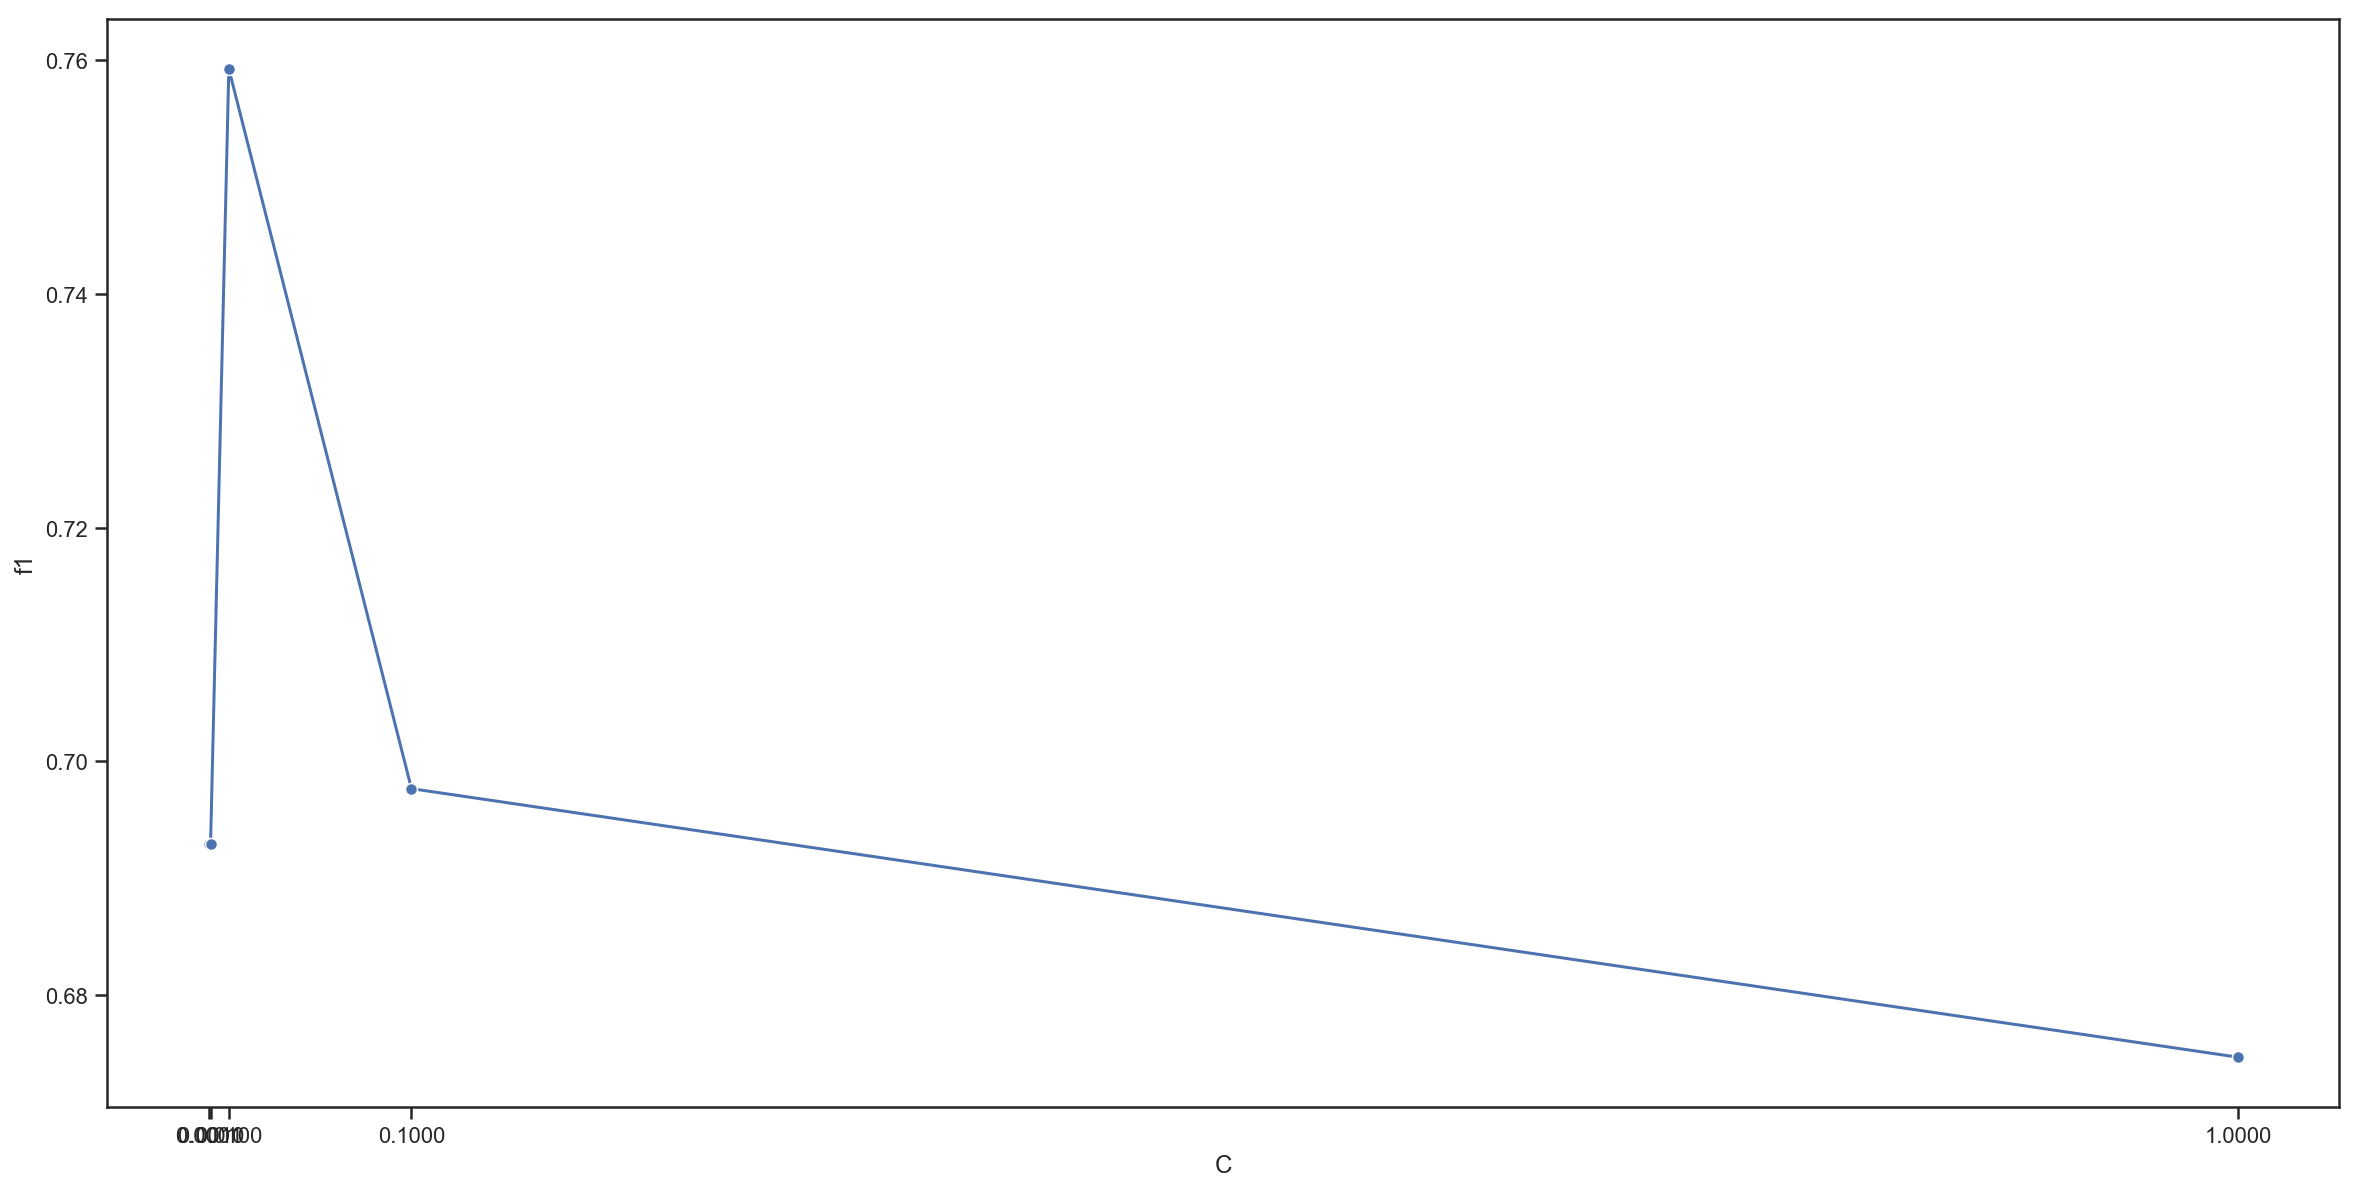

In [24]:
c_candidates = [0.0001, 0.001, 0.01, 0.1, 1]
f1s = []

for c in c_candidates:
    f1s.append(get_f1(c))
    
ax = sns.lineplot(x=c_candidates, y=f1s, marker="o")
ax.set(xlabel="C", ylabel="f1")
ax.set_xticks(c_candidates)
plt.show()

In [25]:
best_c_index = f1s.index(max(f1s))
print(c_candidates[best_c_index])
print(f1s[best_c_index])

0.01
0.7592592592592592


---

In [26]:
classifier = LogisticRegression(random_state=1024, solver="liblinear", C=c_candidates[best_c_index])
classifier.fit(train_df[feature_cols], train_df["release_post"])

LogisticRegression(C=0.01, random_state=1024, solver='liblinear')

In [29]:
dict(zip(feature_cols, classifier.coef_[0]))

{'days_since_previous_release': 0.08721939905643213,
 'weekday_0': -0.11276152488996835,
 'weekday_1': -0.052367533935480264,
 'weekday_2': -0.04396377416112887,
 'weekday_3': 0.01858808415780218,
 'weekday_4': -0.004590312771117035,
 'weekday_5': 0.0024859230027319034,
 'weekday_6': -0.047078852426983744}

In [30]:
days_since_most_recent_release = (datetime.now() - df.iloc[-1]["date"]).days

In [37]:
next_30_days = [(datetime.now() + timedelta(days=i), i + days_since_most_recent_release, 
                 (datetime.now() + timedelta(days=i)).weekday()) for i in range(1, 31)]
future_df = pandas.DataFrame(next_30_days, columns=["date", "days_since_previous_release", "weekday"])
future_df = pandas.get_dummies(future_df, columns=["weekday"], prefix="weekday")
future_df["predicted_release"] = classifier.predict(future_df[feature_cols])
future_df["release_probability"] = [x[1] for x in classifier.predict_proba(future_df[feature_cols])]

future_df

,date,days_since_previous_release,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,predicted_release,release_probability
0,2021-07-08 19:32:26.957200,7,0,0,0,1,0,0,0,True,0.596147
1,2021-07-09 19:32:26.957215,8,0,0,0,0,1,0,0,True,0.611466
2,2021-07-10 19:32:26.957218,9,0,0,0,0,0,1,0,True,0.633619
3,2021-07-11 19:32:26.957221,10,0,0,0,0,0,0,1,True,0.642315
4,2021-07-12 19:32:26.957224,11,1,0,0,0,0,0,0,True,0.647248
5,2021-07-13 19:32:26.957227,12,0,1,0,0,0,0,0,True,0.680175
6,2021-07-14 19:32:26.957231,13,0,0,1,0,0,0,0,True,0.700609
7,2021-07-15 19:32:26.957234,14,0,0,0,1,0,0,0,True,0.731053
8,2021-07-16 19:32:26.957237,15,0,0,0,0,1,0,0,True,0.743457
9,2021-07-17 19:32:26.957240,16,0,0,0,0,0,1,0,True,0.761025
